In [79]:
#importing required modules 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import warnings

import random
import os
import datetime
import time
from pyspark import SparkContext

from pyspark.sql import SparkSession 
from pyspark import SparkContext
%matplotlib inline
warnings.filterwarnings('ignore')

In [80]:
# loading dataset 
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [81]:
# load the dataset and create sprk dataframe

sql_df = spark.read.csv('dataset/Loan_Train.csv', sep=",", inferSchema=True,header=True)

# Using limit(), or select() or show() to view the data. I often use limit()
# Using toPandas() method to return Pyspark DataFrame as Pandas table

sql_df.limit(5).toPandas()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360,1,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360,1,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360,1,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360,1,Urban,Y


In [82]:
sql_df.show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [83]:
sql_df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



***For visualization, converting PySpark Dataframe to Pandas DataFrame***


In [84]:
#from spark.sql df to Panadas df
data = sql_df.toPandas()

In [85]:
# Describing data
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [86]:
#check datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int32  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int32(1), object(8)
memory usage: 60.1+ KB


In [87]:
# filtering out outliers from ApplicantIncome and LoanAmount Column
# Calculate outliers for LoanAmount column
Q1_loan = data['LoanAmount'].quantile(0.25)
Q3_loan = data['LoanAmount'].quantile(0.75)
IQR_loan = Q3_loan - Q1_loan

lower_bound_loan = Q1_loan - (1.5 * IQR_loan)
upper_bound_loan = Q3_loan + (1.5 * IQR_loan)

# Filter outliers for LoanAmount column
outliers_loan = data[(data['LoanAmount'] < lower_bound_loan) | (data['LoanAmount'] > upper_bound_loan)]

# Calculate outliers for ApplicantIncome column
Q1_income = data['ApplicantIncome'].quantile(0.25)
Q3_income = data['ApplicantIncome'].quantile(0.75)
IQR_income = Q3_income - Q1_income

lower_bound_income = Q1_income - (1.5 * IQR_income)
upper_bound_income = Q3_income + (1.5 * IQR_income)

# Filter outliers for ApplicantIncome column
outliers_income = data[(data['ApplicantIncome'] < lower_bound_income) | (data['ApplicantIncome'] > upper_bound_income)]

# Create filtered DataFrame without outliers
filtered_data_df = data[~(data['LoanAmount'].isin(outliers_loan['LoanAmount']) | data['ApplicantIncome'].isin(outliers_income['ApplicantIncome']))]



In [88]:
filtered_data_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,547.000000,547.000000,527.000000,533.000000,502.000000
mean,4047.550274,1537.052870,127.396584,342.101313,0.840637
std,1855.553192,2380.417249,46.334010,65.971721,0.366379
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2719.000000,0.000000,99.000000,360.000000,1.000000
50%,3597.000000,1330.000000,122.000000,360.000000,1.000000
75%,4906.000000,2264.500000,155.000000,360.000000,1.000000
max,10139.000000,33837.000000,267.000000,480.000000,1.000000


In [89]:
filtered_data_df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int32
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [90]:
filtered_data_df['Loan_Status'].value_counts()

Y    379
N    168
Name: Loan_Status, dtype: int64

In [91]:
# Dropping Loan_ID column
filtered_data_df.drop(['Loan_ID'],axis=1,inplace=True)

## Filling NULL values 

In [92]:
#check null values
filtered_data_df.isnull().sum()

Gender                9
Married               3
Dependents           14
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           20
Loan_Amount_Term     14
Credit_History       45
Property_Area         0
Loan_Status           0
dtype: int64

In [93]:
# Check the number of null values in each row
null_rows = filtered_data_df.isnull().sum(axis=1)

# Count the number of rows with null values
num_null_rows = null_rows[null_rows > 0].count()

# Display the count
print("Number of rows with null values:", num_null_rows)

Number of rows with null values: 121


In [94]:
#filling null values-- filling in null values with mode or mean values of the data. So if gender has more male than female, then we will fill Null values with Male. 

filtered_data_df.Gender.fillna(filtered_data_df['Gender'].mode()[0], inplace=True)

filtered_data_df.Married.fillna(filtered_data_df['Married'].mode()[0], inplace=True)

filtered_data_df['Dependents'].fillna(filtered_data_df['Dependents'].mode()[0], inplace=True)


filtered_data_df.Self_Employed.fillna(filtered_data_df['Self_Employed'].mode()[0], inplace=True)

filtered_data_df['LoanAmount'].fillna(filtered_data_df['LoanAmount'].mean(), inplace=True) # Mean


filtered_data_df['Loan_Amount_Term'].fillna(filtered_data_df['Loan_Amount_Term'].mean(), inplace=True)

filtered_data_df['Credit_History'].fillna(filtered_data_df['Credit_History'].mode()[0], inplace=True) # Mode


In [95]:
# checking to see if null values are filled using describe
filtered_data_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,547.000000,547.000000,547.000000,547.000000,547.000000
mean,4047.550274,1537.052870,127.396584,342.101313,0.853748
std,1855.553192,2380.417249,45.477485,65.120437,0.353682
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2719.000000,0.000000,100.000000,360.000000,1.000000
50%,3597.000000,1330.000000,125.000000,360.000000,1.000000
75%,4906.000000,2264.500000,153.500000,360.000000,1.000000
max,10139.000000,33837.000000,267.000000,480.000000,1.000000


# Exploratory Data Analysis

Number of people who take loan as group by Gender
Male      489
Female    112
Name: Gender, dtype: int64


<Axes: xlabel='Gender', ylabel='count'>

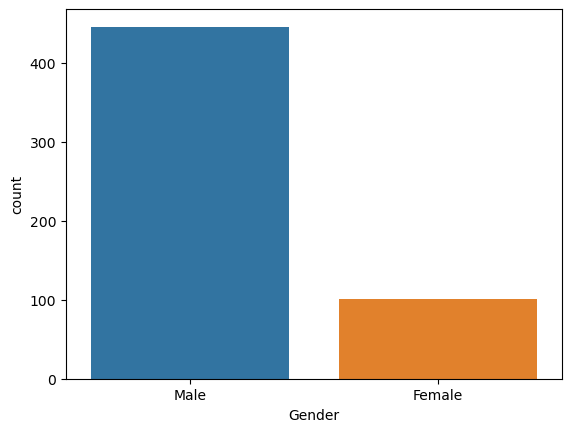

In [96]:
print("Number of people who take loan as group by Gender")
print(data['Gender'].value_counts())
sns.countplot(x="Gender",data=filtered_data_df)

Number of people who take loan as group by marital Status
Yes    398
No     213
Name: Married, dtype: int64


<Axes: xlabel='Married', ylabel='count'>

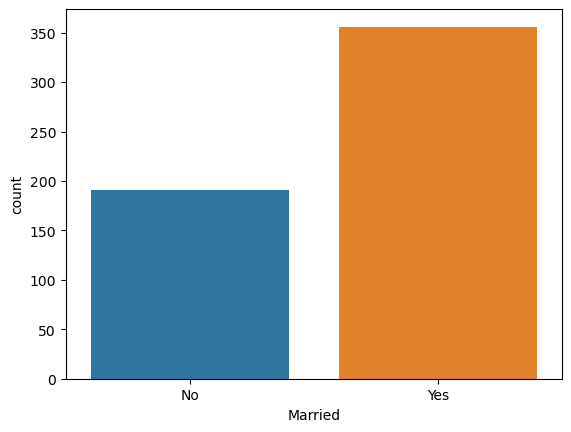

In [97]:
print("Number of people who take loan as group by marital Status")
print(data['Married'].value_counts())
sns.countplot(x="Married",data=filtered_data_df)

Number of people who take loan as group by Dependents
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


<Axes: xlabel='Dependents', ylabel='count'>

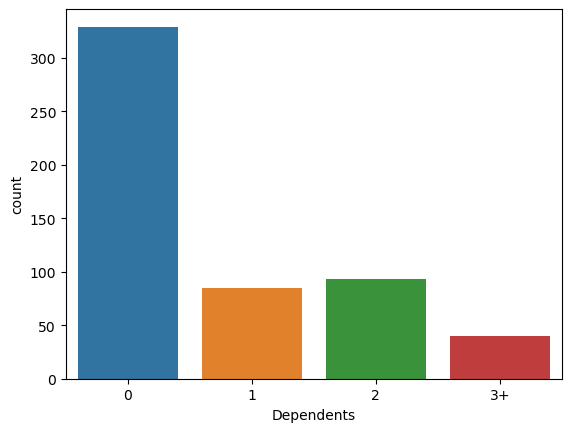

In [98]:
print("Number of people who take loan as group by Dependents")
print(data['Dependents'].value_counts())
sns.countplot(x="Dependents",data=filtered_data_df)

Number of people who take loan as group by Self_Employed
No     500
Yes     82
Name: Self_Employed, dtype: int64


<Axes: xlabel='Self_Employed', ylabel='count'>

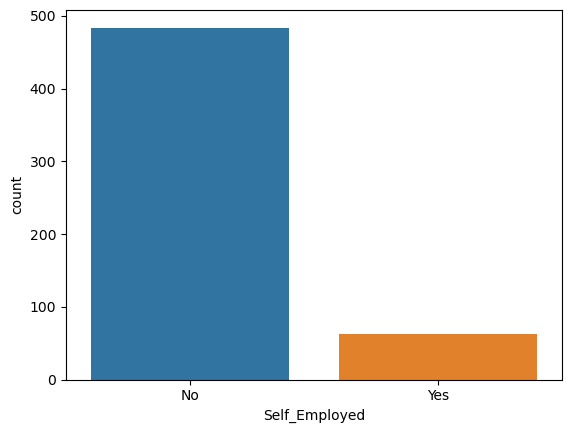

In [99]:
print("Number of people who take loan as group by Self_Employed")
print(data['Self_Employed'].value_counts())
sns.countplot(x="Self_Employed",data=filtered_data_df)

Number of people who take loan as group by Property_Area
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


(array([0, 1, 2]),
 [Text(0, 0, 'Urban'), Text(1, 0, 'Rural'), Text(2, 0, 'Semiurban')])

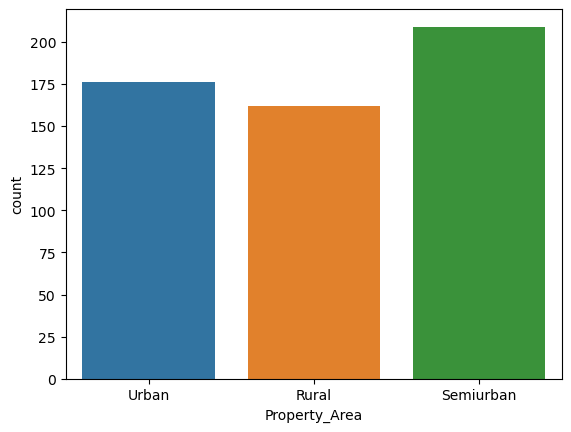

In [100]:
print("Number of people who take loan as group by Property_Area")
print(data['Property_Area'].value_counts())
sns.countplot(x="Property_Area",data=filtered_data_df)
plt.xticks(rotation=0)

Number of people who take loan as group by Education
Graduate        480
Not Graduate    134
Name: Education, dtype: int64


(array([0, 1]), [Text(0, 0, 'Graduate'), Text(1, 0, 'Not Graduate')])

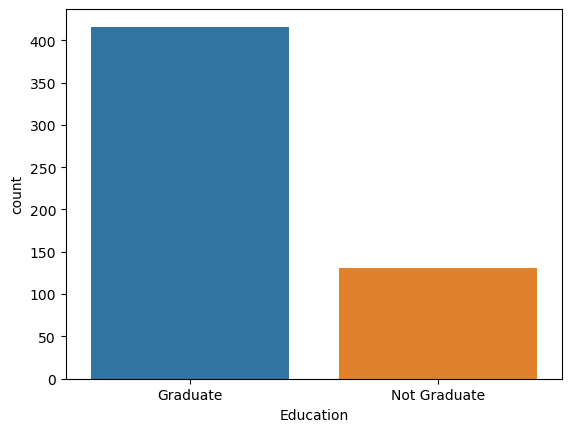

In [101]:
print("Number of people who take loan as group by Education")
print(data['Education'].value_counts())
sns.countplot(x="Education",data=filtered_data_df)
plt.xticks(rotation=0)

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

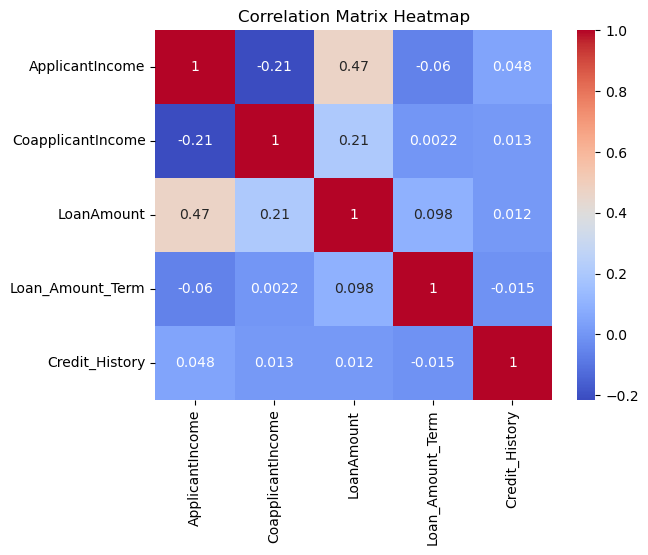

In [102]:
# Compute the correlation matrix ot understand which features are strongly correlated. Using Seaborn. 
corr_matrix = filtered_data_df.corr()

# Create a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

# Set the title of the plot
plt.title('Correlation Matrix Heatmap')

According to the correlation matrix, there is low to moderate correlation established between the variables. The highest correaltion (r=0.47) established between Applicant Income and Loan amount. 

Text(0, 0.5, 'Loan Amount')

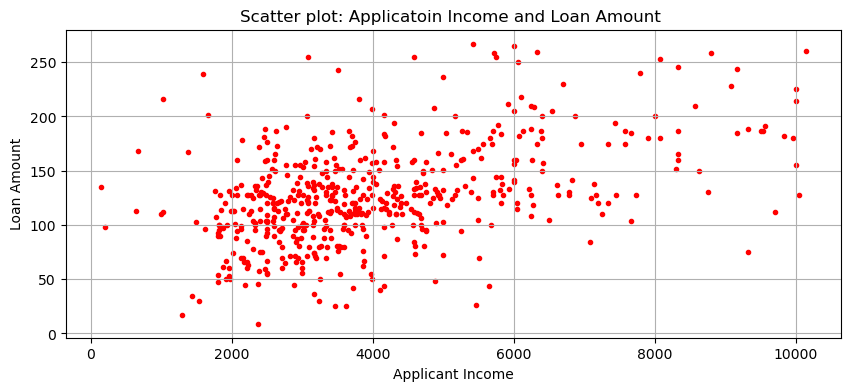

In [103]:
#Applicant income vs loan amount plot
plt.figure(figsize=(10, 4))
plt.title("Scatter plot: Applicatoin Income and Loan Amount ")
plt.grid()
plt.scatter(filtered_data_df['ApplicantIncome'], filtered_data_df['LoanAmount'], c='red', marker='.')
plt.xlabel("Applicant Income")
plt.ylabel("Loan Amount")

Being moderately correlated, spread in data between Applicant Income and Loan Amount is clearly visualized.

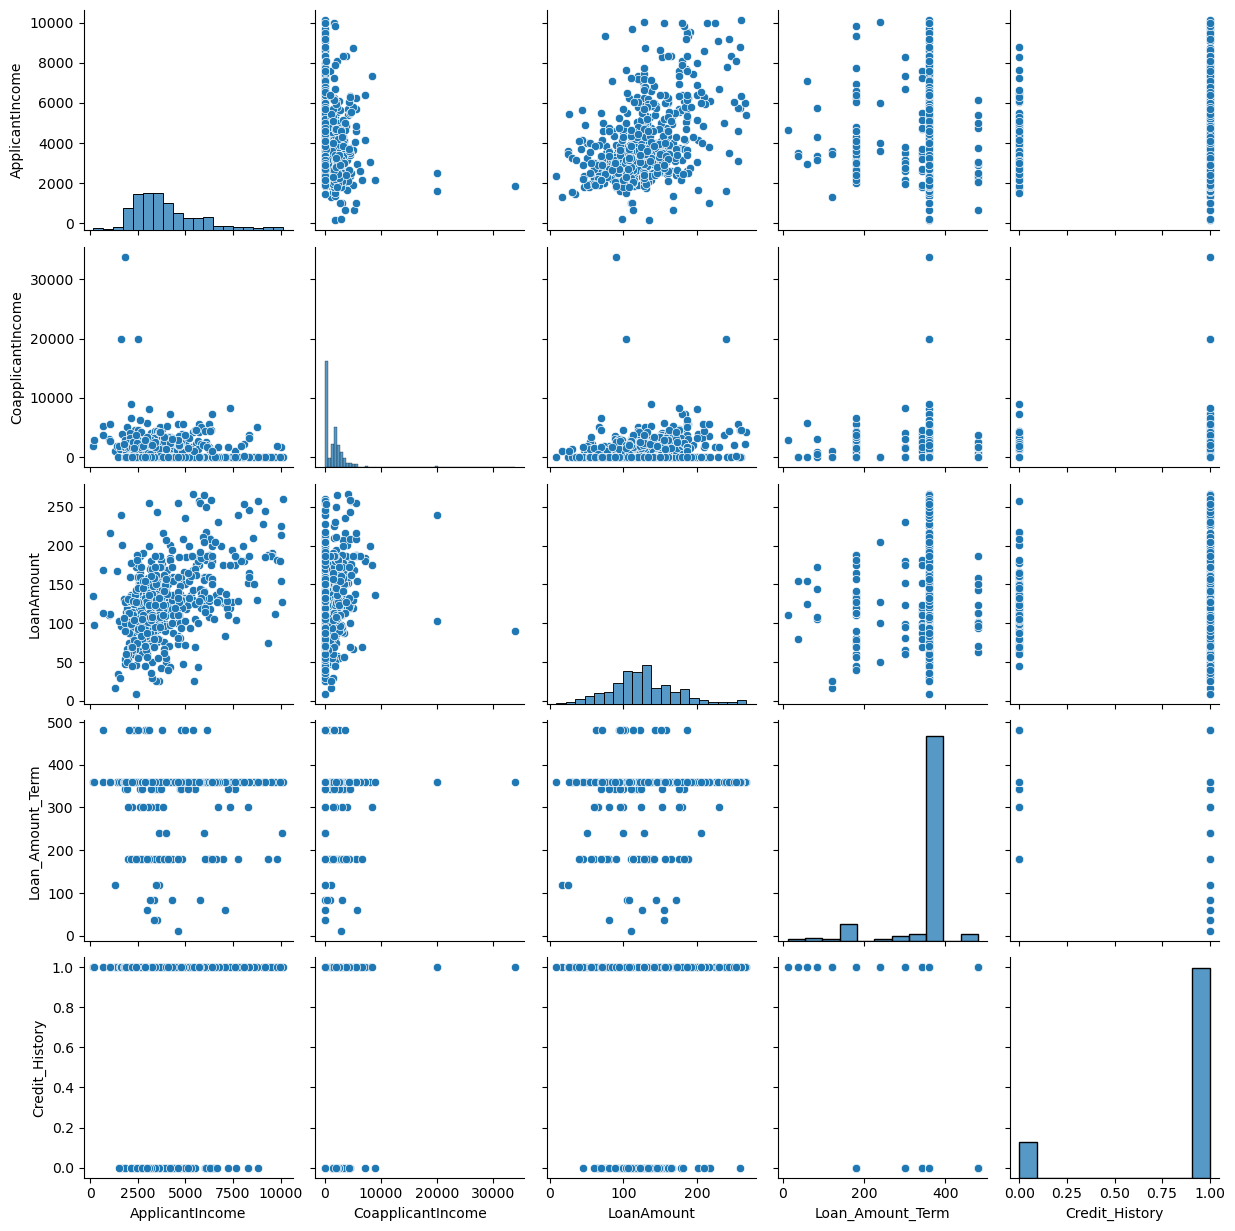

In [104]:
#Pairplot of the filtered dataset
sns.pairplot(filtered_data_df)

Data is showing high variance and hence linear models would not be applicable to this dataset.

Text(0.5, 1.0, 'Histogram Plot: Loan Application Amount')

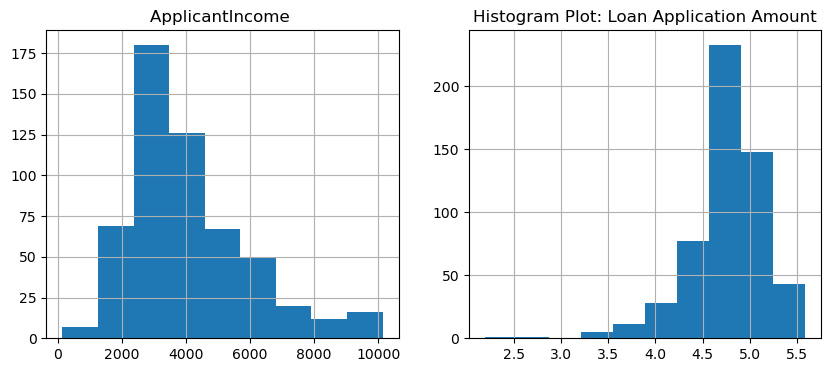

In [105]:
#Histogram Plot to visualize distribution of data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
filtered_data_df['ApplicantIncome'].hist(bins=9)
plt.title("ApplicantIncome ")
plt.subplot(1, 2, 2)
plt.grid()
plt.hist(np.log(filtered_data_df['LoanAmount']))
plt.title("Histogram Plot: Loan Application Amount")

Variables 'Applicant Income' and 'Loan Amount' are skewed.  

Text(0.5, 1.0, 'Box Plot: Applicant Income')

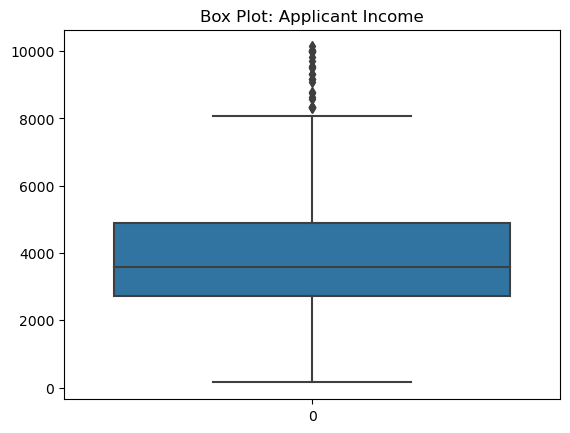

In [106]:
# Box Plot
sns.boxplot(filtered_data_df['ApplicantIncome'])
plt.title("Box Plot: Applicant Income")

The average Applicant's income is in the range of Dollar 2,000 - 5,000. Even after filtering the raw data for outliers, income above Dollar 8000 (upper boundary) is appearing as outlier.

Text(0.5, 1.0, 'Box Plot: Loan Amount ')

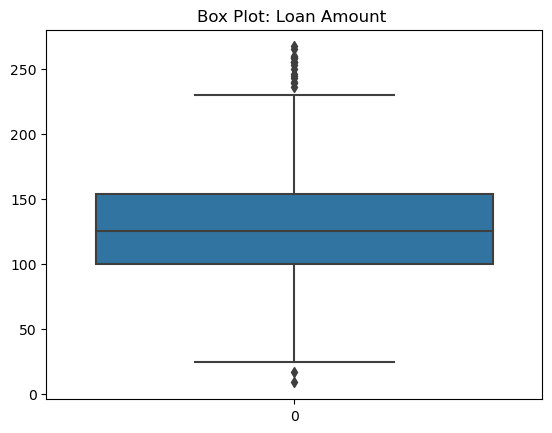

In [107]:
sns.boxplot(filtered_data_df['LoanAmount'])
plt.title("Box Plot: Loan Amount ")

Loan request below Dollar 25,000 and above Dollar 2,25,000 is resulting as outlier. Dataset has already been cleaned for outliers, We are keeping these values for building the models.

# Splitting Dataset for Model Implenmentation

In [108]:
#Considering Loan Status as Dependant Variable
X = filtered_data_df.drop(['Loan_Status'],axis=1)
Y = filtered_data_df['Loan_Status']

In [109]:
#spliting train test data. Keeping 70% of data as training and 30 % data as testing

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3,random_state=1)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((382, 11), (165, 11), (382,), (165,))

In [110]:
#training test data
X_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
49,Female,No,0,Graduate,No,4000,2275.0,144.0,360.0,1.0,Semiurban
573,Male,Yes,2,Not Graduate,No,6125,1625.0,187.0,480.0,1.0,Semiurban
531,Male,Yes,3+,Graduate,No,4281,0.0,100.0,360.0,1.0,Urban
98,Male,Yes,0,Not Graduate,No,4188,0.0,115.0,180.0,1.0,Semiurban
501,Female,No,0,Graduate,No,3159,0.0,100.0,360.0,1.0,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...
143,Male,Yes,0,Graduate,No,2698,2034.0,122.0,360.0,1.0,Semiurban
162,Male,Yes,1,Graduate,No,3089,1280.0,121.0,360.0,0.0,Semiurban
77,Male,Yes,1,Graduate,Yes,1000,3022.0,110.0,360.0,1.0,Urban
264,Male,No,0,Graduate,Yes,5166,0.0,128.0,360.0,1.0,Semiurban


In [111]:
Y_train

49     Y
573    N
531    Y
98     Y
501    Y
      ..
143    Y
162    N
77     N
264    Y
40     N
Name: Loan_Status, Length: 382, dtype: object

In [112]:
X_test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
541,Female,No,0,Graduate,No,2138,0.0,99.000000,360.0,0.0,Semiurban
95,Male,No,0,Graduate,No,6782,0.0,127.396584,360.0,1.0,Urban
287,Male,Yes,0,Graduate,No,3704,2000.0,120.000000,360.0,1.0,Rural
360,Female,No,1,Graduate,No,4723,0.0,81.000000,360.0,1.0,Semiurban
548,Female,No,0,Graduate,No,5000,0.0,103.000000,360.0,0.0,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...
387,Male,Yes,0,Not Graduate,No,3010,3136.0,127.396584,360.0,0.0,Urban
593,Male,Yes,0,Graduate,No,3859,3300.0,142.000000,180.0,1.0,Rural
611,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban
262,Female,No,1,Graduate,No,3481,0.0,155.000000,36.0,1.0,Semiurban


In [113]:
Y_test

541    N
95     N
287    Y
360    N
548    N
      ..
387    N
593    Y
611    Y
262    N
85     Y
Name: Loan_Status, Length: 165, dtype: object

## convert Categorical variable with Numerical values.

In [114]:
X_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [115]:
# Encoding categorical data
# Encoding the Independent Variable

columns = ['Gender','Married','Dependents','Education','Self_Employed']
labelencoder_X = LabelEncoder()
for i,col in enumerate(columns):
    
    X_train[col] = labelencoder_X.fit_transform(X_train.iloc[:,i])

X_train["Property_Area"] = labelencoder_X.fit_transform(X_train.iloc[:,10])

In [116]:
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
Y_train = labelencoder_y.fit_transform(Y_train)

In [117]:
X_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
49,0,0,0,0,0,4000,2275.0,144.0,360.0,1.0,1
573,1,1,2,1,0,6125,1625.0,187.0,480.0,1.0,1
531,1,1,3,0,0,4281,0.0,100.0,360.0,1.0,2
98,1,1,0,1,0,4188,0.0,115.0,180.0,1.0,1
501,0,0,0,0,0,3159,0.0,100.0,360.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
143,1,1,0,0,0,2698,2034.0,122.0,360.0,1.0,1
162,1,1,1,0,0,3089,1280.0,121.0,360.0,0.0,1
77,1,1,1,0,1,1000,3022.0,110.0,360.0,1.0,2
264,1,0,0,0,1,5166,0.0,128.0,360.0,1.0,1


In [118]:
Y_train

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,

In [119]:
# Encoding categorical data (testing data)
# Encoding the Independent Variable

labelencoder_X = LabelEncoder()

for i,col in enumerate(columns):
    X_test[col] = labelencoder_X.fit_transform(X_test.iloc[:,i])

X_test["Property_Area"] = labelencoder_X.fit_transform(X_test.iloc[:,10])
    
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
Y_test = labelencoder_y.fit_transform(Y_test)

In [120]:
X_test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
541,0,0,0,0,0,2138,0.0,99.000000,360.0,0.0,1
95,1,0,0,0,0,6782,0.0,127.396584,360.0,1.0,2
287,1,1,0,0,0,3704,2000.0,120.000000,360.0,1.0,0
360,0,0,1,0,0,4723,0.0,81.000000,360.0,1.0,1
548,0,0,0,0,0,5000,0.0,103.000000,360.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
387,1,1,0,1,0,3010,3136.0,127.396584,360.0,0.0,2
593,1,1,0,0,0,3859,3300.0,142.000000,180.0,1.0,0
611,1,1,1,0,0,8072,240.0,253.000000,360.0,1.0,2
262,0,0,1,0,0,3481,0.0,155.000000,36.0,1.0,1


In [121]:
Y_test

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1])

In [122]:
# Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [123]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [124]:


start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.022 seconds


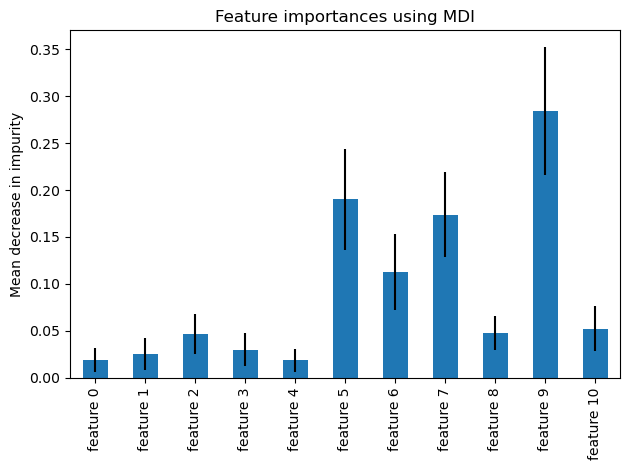

In [125]:
# top features 5, 7, and 9 ( ApplicantIncome, LoanAmount, and Credit_History)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Top features are 

5: Applicant Income, 

7: Loan Amount, and

9: Credit History

# Model Training and Evaluation

In [126]:
#Training  the Models
def model_report(models,X_train,X_test,y_train,y_test):
    for name, model in models:
        model.fit(X_train, y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test  = model.predict(X_test)
        print("_"*80)
        print(f"Report For {name}".center(80))
        print()
        print(f"Training Accuracy: {accuracy_score(y_train, y_hat_train):.2f}")
        print(f"Test     Accuracy: {accuracy_score(y_test, y_hat_test):.2f}")
        print()
        #print(f"Training Accuracy: {confusion_matrix(y_train, y_hat_train)}")
        print(f"Test     Accuracy: {confusion_matrix(y_test, y_hat_test)}")
        print()
        print(f"Training Accuracy: {classification_report(y_train, y_hat_train)}")
        print(f"Test     Accuracy: {classification_report(y_test, y_hat_test)}")
        print('\n\n')

In [127]:
#Preparing different models KNeighborsClassifier, RandomForestClassifier, SVC, Logistic Regression Classifier, GaussianNB
  
knn = KNeighborsClassifier(n_neighbors=5)

rfc = RandomForestClassifier(max_depth=2, random_state=10)

svc = SVC(degree=3, gamma='auto')

lc = LogisticRegression(solver='lbfgs', random_state=1)

classifier = GaussianNB()

dt = DecisionTreeClassifier(max_depth=3, min_samples_split=3, min_samples_leaf=1, random_state=1)


model = [
    ('LogisticRegression',lc),
    ('KNeighborsClassifier',knn),
    ('svc',svc),
    ('RandomForestClassifier',rfc),
    ('GaussianNB',classifier),
    ('DecisionTreeClassifier',dt)
]

In [128]:
#Performance report of each model
model_report(model,X_train,X_test,Y_train,Y_test)


________________________________________________________________________________
                         Report For LogisticRegression                          

Training Accuracy: 0.83
Test     Accuracy: 0.79

Test     Accuracy: [[ 23  31]
 [  3 108]]

Training Accuracy:               precision    recall  f1-score   support

           0       0.94      0.45      0.61       114
           1       0.81      0.99      0.89       268

    accuracy                           0.83       382
   macro avg       0.88      0.72      0.75       382
weighted avg       0.85      0.83      0.81       382

Test     Accuracy:               precision    recall  f1-score   support

           0       0.88      0.43      0.57        54
           1       0.78      0.97      0.86       111

    accuracy                           0.79       165
   macro avg       0.83      0.70      0.72       165
weighted avg       0.81      0.79      0.77       165




__________________________________________________

## Model Optimization 

In [129]:
from sklearn.model_selection import GridSearchCV

# Optimization of Models

***Out of five, Three Models are optimized to select the best performing model for the testing.***

### **Logistic Regression Model**

In [130]:
#Parameters selection and Cross Validation for Logistic Regression Model fit

param_grid = {  
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000],
    }

grid_search = GridSearchCV(lc, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

grid_search.fit(X_train, Y_train)

print('Best score for Logistic model: {}'.format(grid_search.best_score_))

print('Best parameters for Logistic model: {}'.format(grid_search.best_params_))

Fitting 3 folds for each of 800 candidates, totalling 2400 fits
Best score for Logistic model: 0.8272227690288713
Best parameters for Logistic model: {'C': 0.004832930238571752, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [131]:
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=1), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [100, 1000, 2500, 5000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']},
             verbose=True)

In [132]:
#best_parameters for Logistic Regression

best_model_lc = grid_search.best_estimator_
best_model_lc 

LogisticRegression(C=0.004832930238571752, random_state=1, solver='liblinear')

In [133]:
#Evaluation of Models for the Logistic Regression

logreg2=LogisticRegression(C=0.0001,penalty="l2", solver="liblinear")
logreg2.fit(X_train,Y_train)
print("score",logreg2.score(X_test,Y_test))

score 0.793939393939394


In [134]:
results_lc_Model = grid_search.cv_results_
print(results_lc_Model)

{'mean_fit_time': array([0.0001661 , 0.00016038, 0.00080864, 0.00017667, 0.00095137,
       0.00277829, 0.00450611, 0.00074776, 0.0012668 , 0.0017573 ,
       0.00014003, 0.0003949 , 0.0007147 , 0.00016069, 0.00103807,
       0.0018839 , 0.00291514, 0.00076874, 0.00115029, 0.00136868,
       0.00024557, 0.00016578, 0.000887  , 0.00012787, 0.00126465,
       0.00277034, 0.00308601, 0.00068196, 0.0014596 , 0.00248702,
       0.00029643, 0.00044719, 0.00103378, 0.00014663, 0.00125798,
       0.00163635, 0.00242496, 0.0006845 , 0.00110054, 0.00131822,
       0.00014345, 0.00012215, 0.00088938, 0.00013773, 0.00192356,
       0.00189018, 0.00247176, 0.00062497, 0.00231163, 0.00146818,
       0.00024319, 0.00036701, 0.00071192, 0.00015036, 0.00079377,
       0.0015707 , 0.00417352, 0.00111365, 0.00114457, 0.00107789,
       0.00025535, 0.00042566, 0.00191681, 0.00040181, 0.00075674,
       0.00159534, 0.00223541, 0.00063491, 0.00106231, 0.00142948,
       0.00012859, 0.00011969, 0.00082882, 0

In [135]:
logestic_Model_df = pd.DataFrame(results_lc_Model)
logestic_Model_df.to_csv("Model_results/logistic_Model_Result.csv")

### SVC model

In [59]:
#Model parameters for SVC model fit

parameter_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

grid_search = GridSearchCV(svc, param_grid = parameter_grid, n_jobs=-1)

grid_search.fit(X_train, Y_train)

print('Best score: {}'.format(grid_search.best_score_))

print('Best parameters: {}'.format(grid_search.best_params_))

svc = SVC(probability=True, gamma='scale', **grid_search.best_params_) 


Best score: 0.8272385509227614
Best parameters: {'C': 0.01, 'kernel': 'linear'}


In [60]:
grid_search.fit(X_train, Y_train)

GridSearchCV(estimator=SVC(gamma='auto'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [61]:
best_model_SVC = grid_search.best_estimator_
best_model_SVC 

SVC(C=0.01, gamma='auto', kernel='linear')

In [62]:
results_SVC = grid_search.cv_results_
#print(result1)

In [63]:
predict = grid_search.predict(X_test)
print(classification_report(Y_test,predict))

              precision    recall  f1-score   support

           0       0.88      0.43      0.57        54
           1       0.78      0.97      0.86       111

    accuracy                           0.79       165
   macro avg       0.83      0.70      0.72       165
weighted avg       0.81      0.79      0.77       165



In [64]:
SVC_df = pd.DataFrame(results_SVC)
#SVC_df.to_csv("Model_results/SVC_ModelResult.csv")

###  Random Forest Classifier

In [65]:

param_grid = {
'n_estimators': [25, 50, 100, 150],
'max_features': ['sqrt', 'log2', None],
'max_depth': [3, 6, 9],
'max_leaf_nodes': [3, 6, 9],
}

forest = RandomForestClassifier(n_jobs=-1)

grid_search = GridSearchCV(forest, param_grid, cv=5,
                      scoring="accuracy", return_train_score=True)

In [66]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]},
             return_train_score=True, scoring='accuracy')

In [67]:
best_model = grid_search.best_estimator_
best_model 

RandomForestClassifier(max_depth=9, max_features='log2', max_leaf_nodes=3,
                       n_estimators=25, n_jobs=-1)

In [68]:
best_parameters = grid_search.best_params_
best_parameters

{'max_depth': 9,
 'max_features': 'log2',
 'max_leaf_nodes': 3,
 'n_estimators': 25}

In [69]:
results_RFC_Model = grid_search.cv_results_
results_RFC_Model

{'mean_fit_time': array([0.04647384, 0.02986379, 0.05511117, 0.07965002, 0.01972394,
        0.03154626, 0.05306501, 0.07933068, 0.01696706, 0.02864976,
        0.05593586, 0.08053255, 0.01637063, 0.02712154, 0.05094519,
        0.07304921, 0.01591735, 0.02615561, 0.04915018, 0.08026423,
        0.01854372, 0.03307314, 0.05253739, 0.07915316, 0.01909428,
        0.03043342, 0.05406656, 0.0883512 , 0.01940908, 0.03149261,
        0.06080952, 0.08973746, 0.01956038, 0.03153219, 0.06079082,
        0.08767481, 0.01769018, 0.03058457, 0.05646586, 0.07842498,
        0.01568389, 0.02610254, 0.04880214, 0.07655306, 0.01660304,
        0.0271493 , 0.05171828, 0.07443032, 0.01650758, 0.02895117,
        0.05300059, 0.08312526, 0.01873918, 0.03059464, 0.05202479,
        0.08702941, 0.01722746, 0.0278832 , 0.05446401, 0.07679906,
        0.01673222, 0.02838726, 0.05813842, 0.07968841, 0.01731892,
        0.02792006, 0.05306497, 0.07603774, 0.01710768, 0.028233  ,
        0.05314846, 0.0768435 ,

In [70]:
print(list(results_RFC_Model.keys()))

['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_max_leaf_nodes', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score']


In [71]:
#Saving model results in CSV file

RandomForest_df = pd.DataFrame(results_RFC_Model)
RandomForest_df.to_csv("Model_results/RandomForest_Model_Result.csv")

In [72]:
#Listing Models for the Random Forest
train_scores = results_RFC_Model['mean_train_score']
test_scores  = results_RFC_Model['mean_test_score']
parameters = results_RFC_Model['params']


scores = [ (tr, ts, pr) for tr, ts, pr in zip(train_scores, test_scores, parameters) ]


strformat = "|{:<5}|{:^20}| {:^20}| {}|\n{}\n"
lb =  '_'*110
print(strformat.format("", "Training Score", "Test Score", "Parameters", lb))
for ix, (tr, ts, pr) in enumerate(scores):
    print(strformat.format(ix+1, tr, ts, pr, lb))

|     |   Training Score   |      Test Score     | Parameters|
______________________________________________________________________________________________________________

|1    | 0.8115418407800279 |  0.8088174982911825 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 25}|
______________________________________________________________________________________________________________

|2    | 0.8272259723561556 |  0.8272385509227614 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 50}|
______________________________________________________________________________________________________________

|3    | 0.8285353048323154 |  0.8272385509227614 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 100}|
______________________________________________________________________________________________________________

|4    | 0.8278817100610736 |  0.8272385509227614 | {'max_depth': 3, 'max_features': 's

In [73]:
Top10_RandomForest_Models = pd.DataFrame(train_scores)
Top10_RandomForest_Models.to_csv("Model_results/Top10_RandomForest_Models.csv")

#### The performance of the three models were giving similar output. For further validation,  Random Forest Classifier is selected.

In [74]:
scores.sort(key=lambda x: x[1],reverse=True)

print("Top 10 Models")
strformat = "|{:<5}|{:^20}| {:^20}| {}|\n{}\n"
lb =  '_'*110
print(strformat.format("", "Training Score", "Test Score", "Parameters", lb))
for ix, (tr, ts, pr) in enumerate(scores[:10]):

    print(strformat.format(ix+1, tr, ts, pr, lb))
    

Top 10 Models
|     |   Training Score   |      Test Score     | Parameters|
______________________________________________________________________________________________________________

|1    | 0.8233065466623808 |  0.8298701298701298 | {'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 3, 'n_estimators': 25}|
______________________________________________________________________________________________________________

|2    | 0.8272259723561556 |  0.8272385509227614 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 50}|
______________________________________________________________________________________________________________

|3    | 0.8285353048323154 |  0.8272385509227614 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 100}|
______________________________________________________________________________________________________________

|4    | 0.8278817100610736 |  0.8272385509227614 | {'max_depth': 3, 'max

### Final best value

In [75]:
rfc = RandomForestClassifier(n_jobs=-1,max_depth= 3, max_features= 'sqrt', max_leaf_nodes= 9, n_estimators= 25)

In [76]:
model_report([("RandomForestClassifier",rfc)],X_train,X_test,Y_train,Y_test)

________________________________________________________________________________
                       Report For RandomForestClassifier                        

Training Accuracy: 0.83
Test     Accuracy: 0.79

Test     Accuracy: [[ 23  31]
 [  3 108]]

Training Accuracy:               precision    recall  f1-score   support

           0       0.94      0.45      0.61       114
           1       0.81      0.99      0.89       268

    accuracy                           0.83       382
   macro avg       0.88      0.72      0.75       382
weighted avg       0.85      0.83      0.81       382

Test     Accuracy:               precision    recall  f1-score   support

           0       0.88      0.43      0.57        54
           1       0.78      0.97      0.86       111

    accuracy                           0.79       165
   macro avg       0.83      0.70      0.72       165
weighted avg       0.81      0.79      0.77       165




